In [2]:
%pip install matplotlib


     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/167.0 kB ? eta -:--:--
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     --------- --------------------------- 41.0/167.0 kB 140.3 kB/s eta 0:00:01
     --------------- --------------------- 71.7/167.0 kB 218.6 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/167.0 kB 297.7 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/167.0 kB 297.7 kB/s eta 0:00:01
     ------------------------------ ----- 143.4/167.0 kB 275.0 kB/s eta 0:00:01
     ------------------------------------ 167.0/167.0 kB 295.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.8 MB 1.7 MB/s


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [3]:
%pip install pathlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from pathlib import Path

In [4]:
# Define paths to train and test directories
TRAIN_DIR = Path("data/train")
TEST_DIR = Path("data/test")

In [6]:
# Data augmentation for the training set to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# No augmentation for the test set, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load images from train and test folders
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Validation for test set
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 2313 images belonging to 87 classes.
Found 363 images belonging to 87 classes.
Found 543 images belonging to 87 classes.


In [9]:
# Load ResNet50 without the top layers (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model to avoid training its weights
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [12]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation='relu')(x)  # Another fully connected layer
x = Dropout(0.5)(x)

# Output layer - number of classes should match your dataset
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Create the convlution base
# model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,798,679 (94.60 MB)

 Trainable params: 1,206,871 (4.60 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [13]:
# Add dense layer
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(87, activation='softmax'))

In [ ]:
# model.summary()

In [15]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=[early_stopping])

Epoch 1/25


c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.0158 - loss: 4.6164 - val_accuracy: 0.0098 - val_loss: 4.4952
Epoch 2/25
 1/72 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - accuracy: 0.0625 - loss: 4.3353

C:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.0625 - loss: 4.3353 - val_accuracy: 0.0323 - val_loss: 4.4369
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.0235 - loss: 4.4364 - val_accuracy: 0.0117 - val_loss: 4.4436
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.0000e+00 - loss: 4.4279 - val_accuracy: 0.0000e+00 - val_loss: 4.5001
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.0282 - loss: 4.3763 - val_accuracy: 0.0254 - val_loss: 4.4118
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.0000e+00 - loss: 4.4336 - val_accuracy: 0.0323 - val_loss: 4.4348
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.0412 - loss: 4.2860 - val_accuracy: 0.0605 - val_loss: 4.3642
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.0312 - loss: 4.3445 - val_accuracy: 0.0645 - val_loss: 4.3377
Epoch 9/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.0447 - loss: 4.2113 - val_accuracy: 0.0762 - 

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.1750 - loss: 3.7384
Test accuracy: 0.1619318127632141


In [17]:
# Generate classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step
              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.12      0.50      0.20         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.33      0.25      0.29         4
           6       0.00      0.00      0.00         4
           7       0.11      0.50      0.17         4
           8       1.00      0.20      0.33         5
           9       0.19      0.60      0.29         5
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.12      0.75      0.21         4
          14       0.00      0.00      0.00         4
          15       0.67      0.40      0.50         5
          16       1.00      0.25      0.4

c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

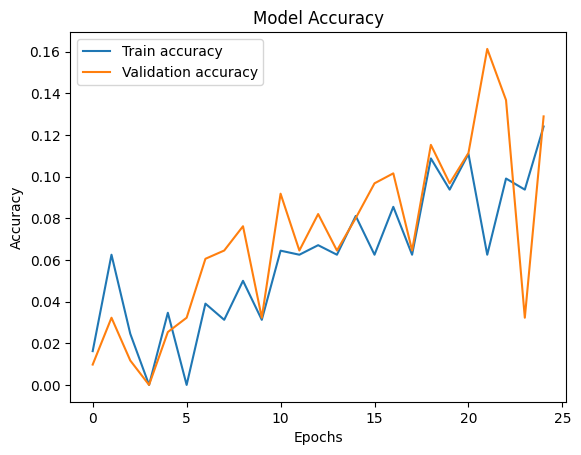

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

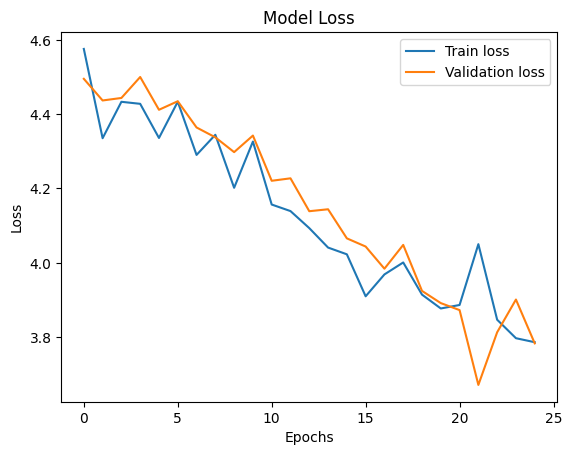

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()